In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
bDataOriginal = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
bDataOriginal.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
bDataOriginal.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [5]:
bDataOriginal.shape

(660, 7)

In [6]:
bDataOriginal.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [7]:
bDataOriginal.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [8]:
bDataOriginal.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [9]:
bDataOriginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


Search for any duplicate customer using Customer Key value

In [10]:
bDataOriginal[bDataOriginal.duplicated(['Customer Key'])]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


Remove the first duplicate row and keep the last one as the most recent record

In [11]:
bDataOriginal.drop_duplicates(subset='Customer Key', keep='last', inplace=True)

Create a new data frame resulted from dropping the id and Customer Key columns that are not necessary for clustering

In [12]:
bData = bDataOriginal.drop(['Sl_No','Customer Key'], axis = 1)

### Scale data using ZScore

In [13]:
from scipy.stats import zscore
bData_z = bData.apply(zscore)

### Bivariate analysis

Pair Plot

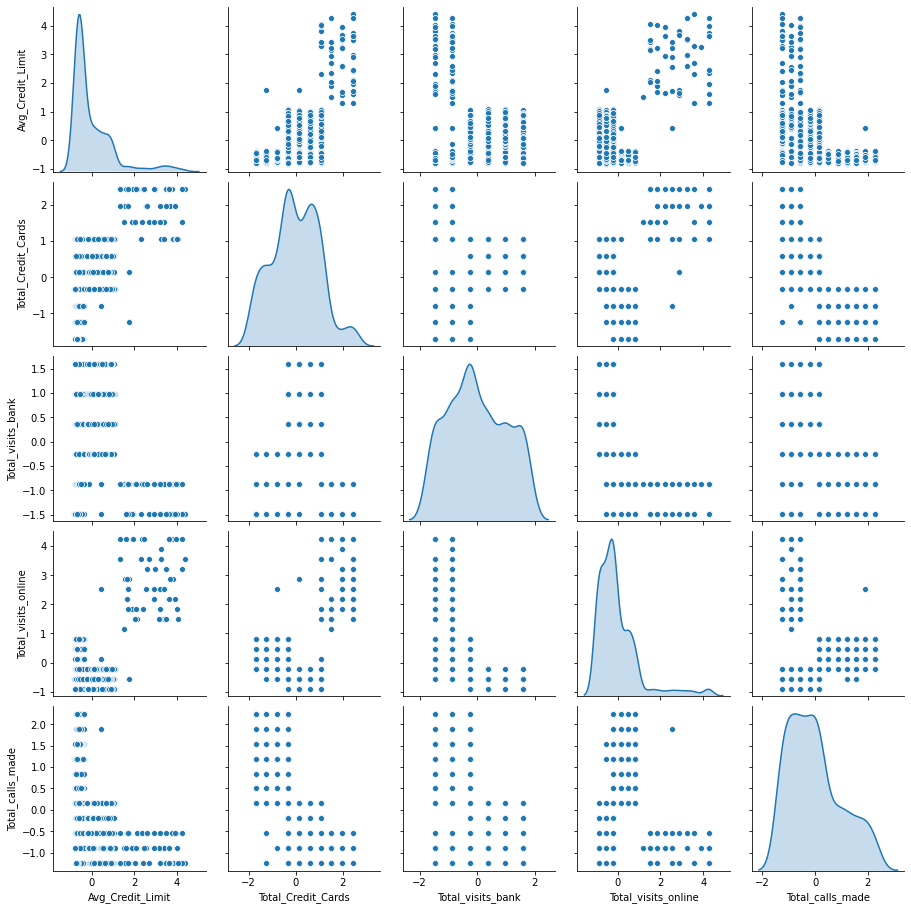

In [14]:
sns.pairplot(bData_z, diag_kind='kde');

Correlation Heatmap

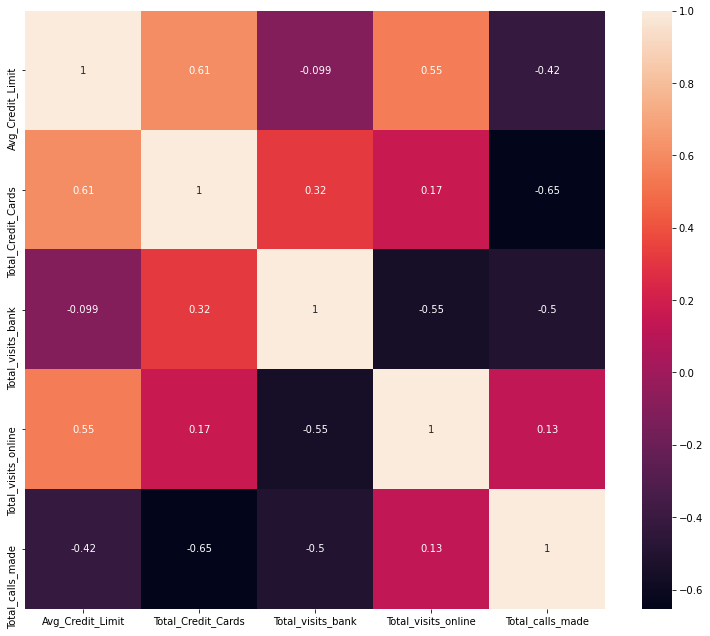

In [15]:
fig, ax = plt.subplots(figsize=(13,11))
sns.heatmap(bData_z.corr(), annot=True);

Finding best K using Elbow Method

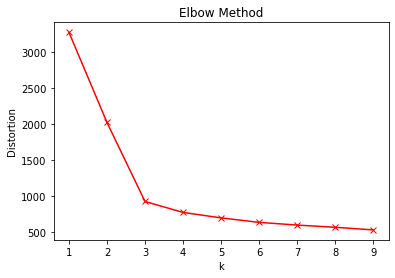

In [16]:
clusters=range(1,10)
distortions=[]

for k in clusters:
    km = KMeans(n_clusters=k)
    km.fit(bData_z)
    distortions.append(km.inertia_)


plt.plot(clusters, distortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


#### The best K is "3"

## KMeans Clustering

In [17]:
km = KMeans(n_clusters = 3, random_state=47)
km.fit(bData_z)

KMeans(n_clusters=3, random_state=47)

Show Centroids

In [18]:
centroids = km.cluster_centers_
cenDF = pd.DataFrame(centroids,  columns=list(bData_z))
cenDF

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.020029,0.374058,0.663236,-0.553313,-0.550293
1,-0.594990,-1.062326,-0.903641,0.331067,1.147911
2,2.852625,1.881592,-1.103557,2.836235,-0.888239


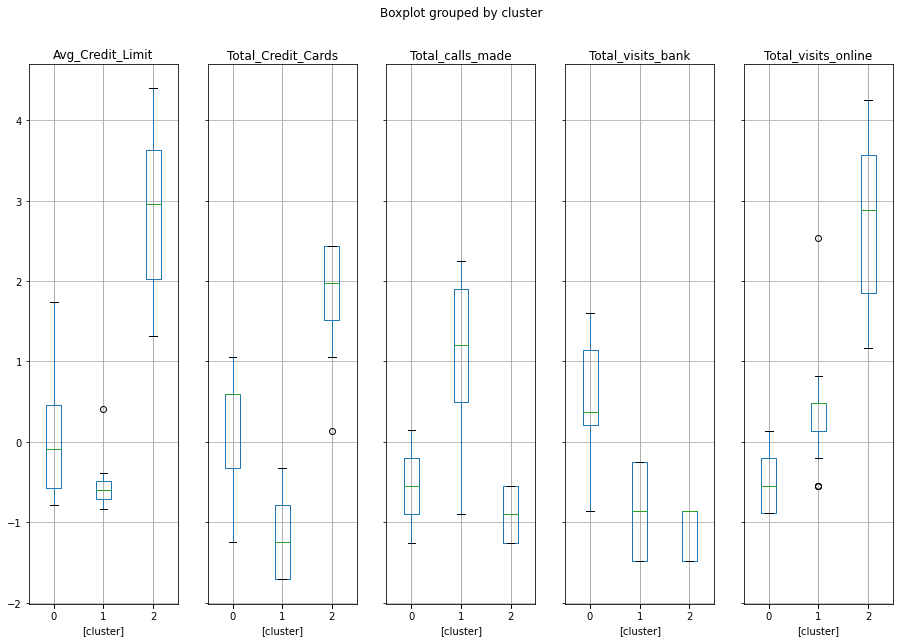

In [19]:
bDataZL = bData_z.copy()
bDataZL['cluster'] = km.labels_
bDataZL.boxplot(by='cluster', layout=(1,5), figsize=(15,10));

## Hierarchical Clustering

In [20]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

In [21]:
from sklearn.cluster import AgglomerativeClustering
hca_s = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
hca_s.fit(bData_z)

AgglomerativeClustering(linkage='single', n_clusters=3)

Agglomerative Clustering with single linkage

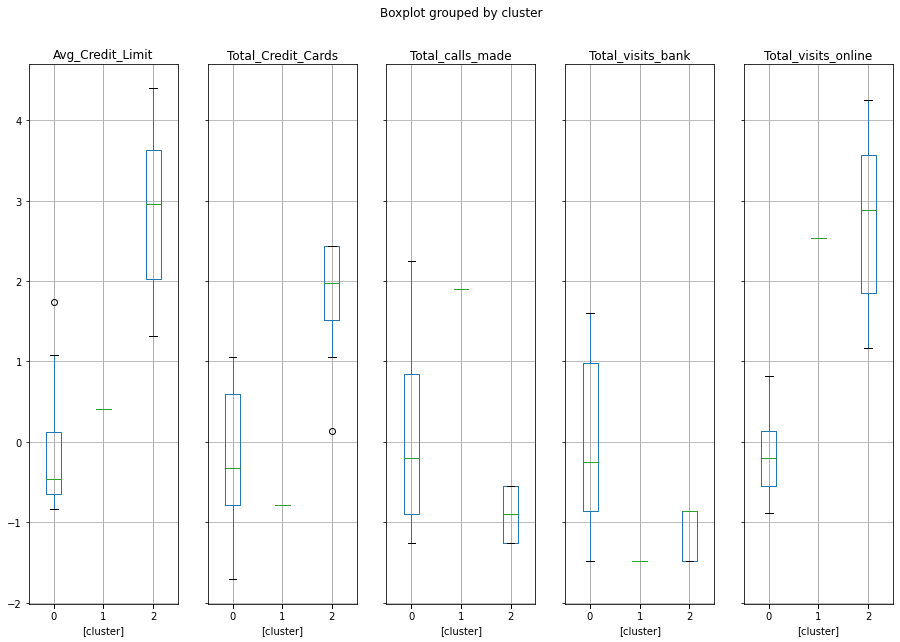

In [22]:
bDataZL_hcs = bData_z.copy()
bDataZL_hcs['cluster'] = hca_s.labels_
bDataZL_hcs.boxplot(by='cluster', layout=(1,5), figsize=(15,10));

In [23]:
zs = linkage(bData_z, metric='euclidean', method='single')
cs, cophe_s = cophenet(zs, pdist(bData_z))
cs

0.7394304750525083

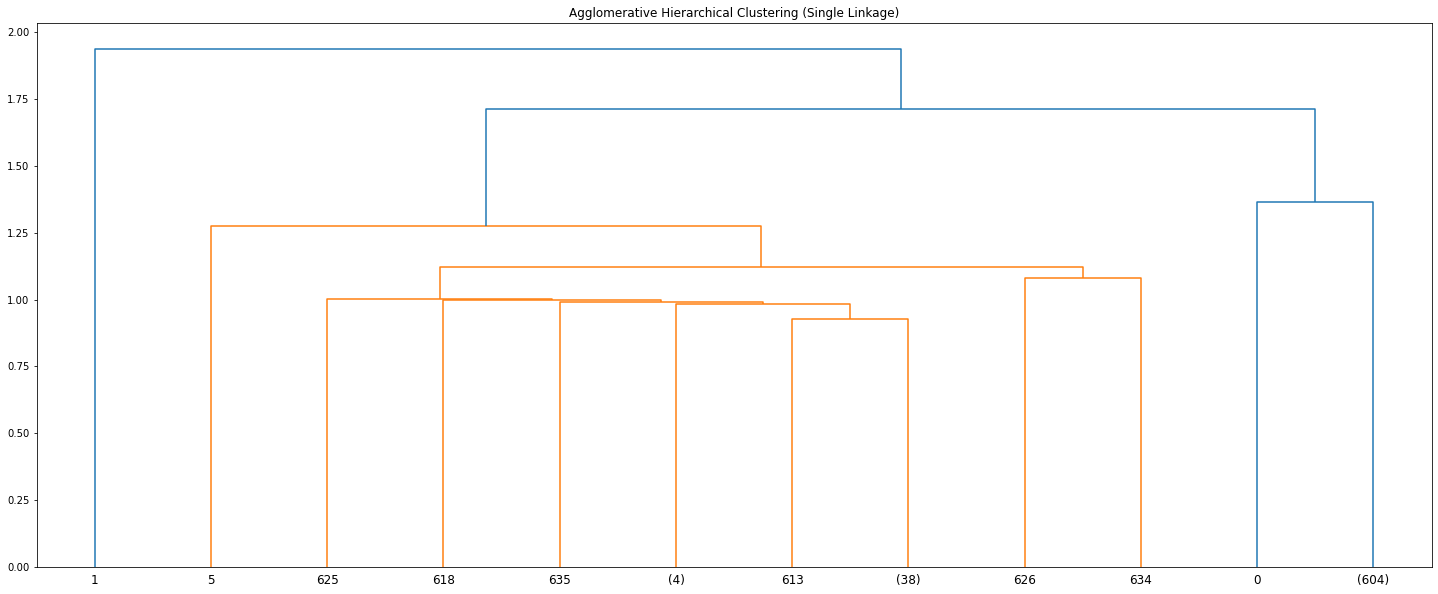

In [24]:
plt.figure(figsize=(25,10))
plt.title('Agglomerative Hierarchical Clustering (Single Linkage)')
dendrogram(zs, truncate_mode='lastp', p = 12)
plt.show()

Agglomerative Clustering with complete linkage

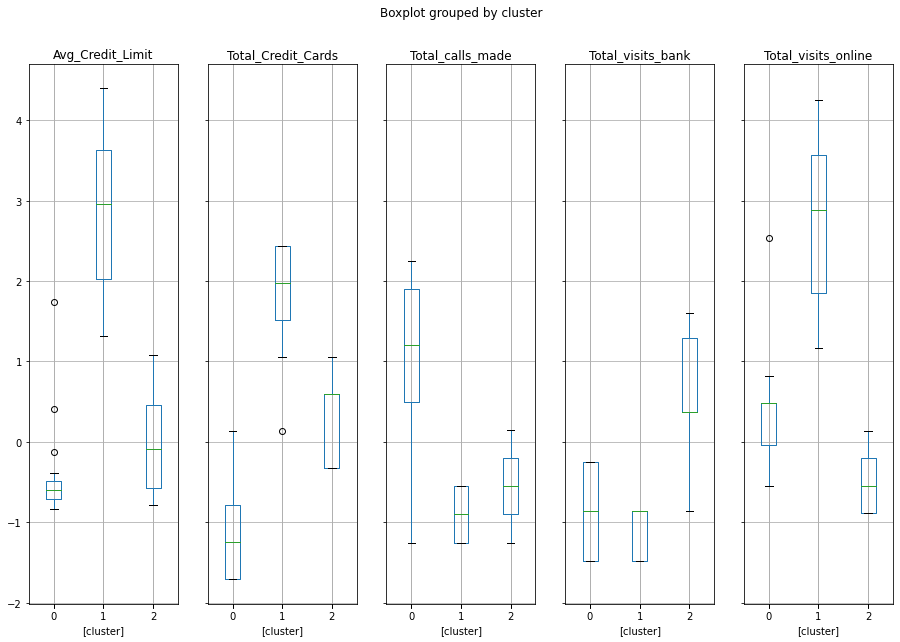

In [25]:
hca_c = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hca_c.fit(bData_z)
bDataZL_hcc = bData_z.copy()
bDataZL_hcc['cluster'] = hca_c.labels_
bDataZL_hcc.boxplot(by='cluster', layout=(1,5), figsize=(15,10));

In [26]:
zc = linkage(bData_z, metric='euclidean', method='complete')
cc, cophe_s = cophenet(zc, pdist(bData_z))
cc

0.8667328091184989

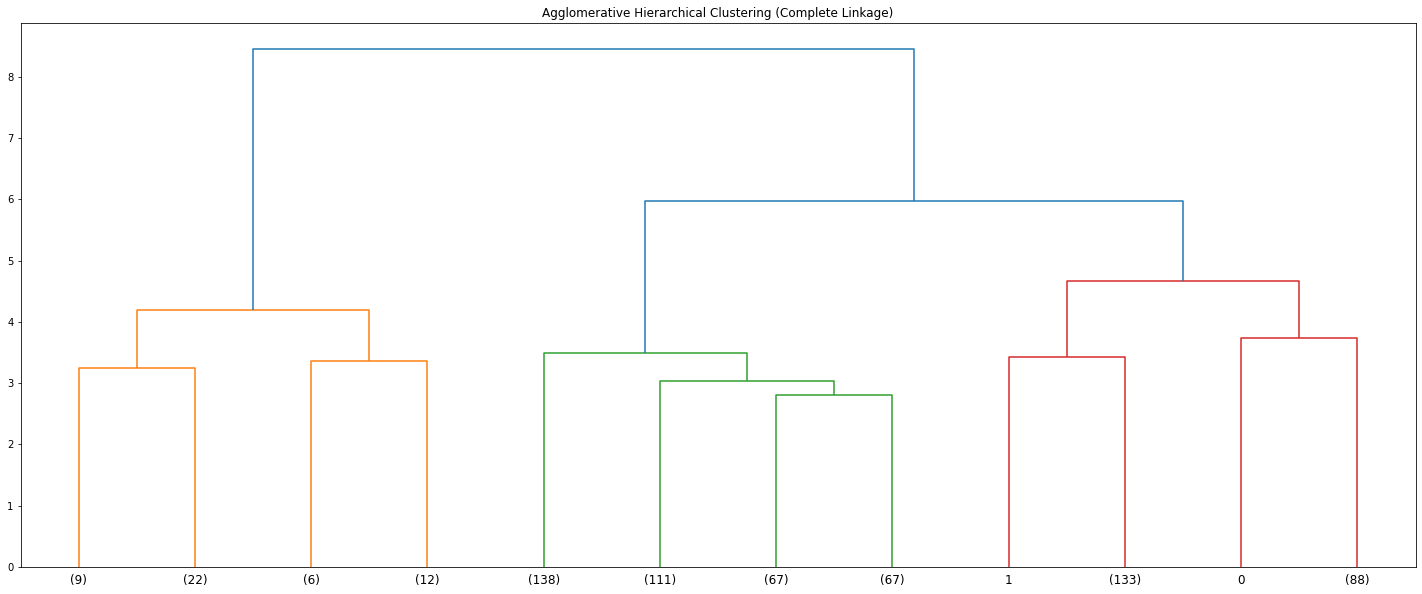

In [27]:
plt.figure(figsize=(25,10))
plt.title('Agglomerative Hierarchical Clustering (Complete Linkage)')
dendrogram(zc, truncate_mode='lastp', p = 12)
plt.show()

Agglomerative Clustering with average linkage

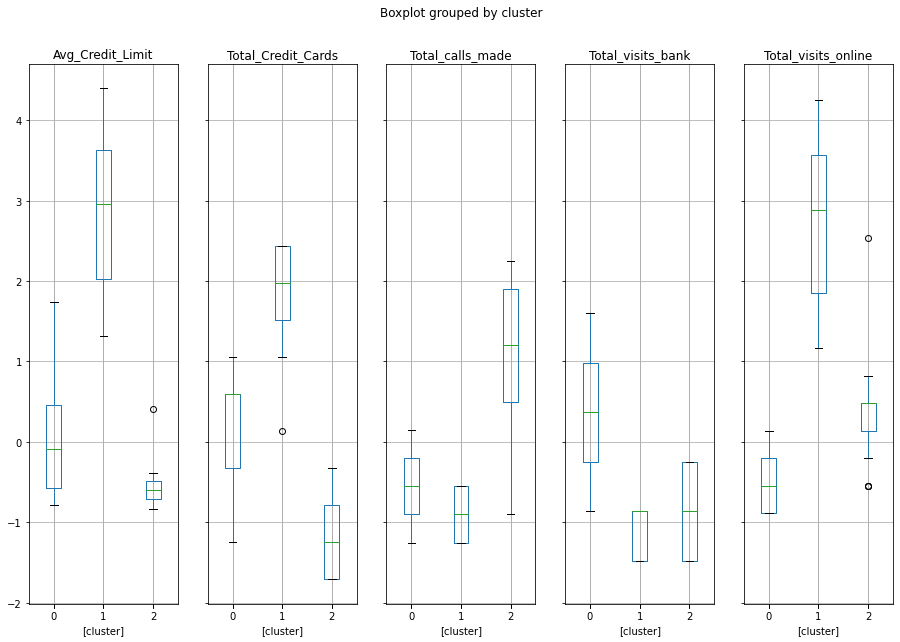

In [28]:
hca_a = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
hca_a.fit(bData_z)
bDataZL_hca = bData_z.copy()
bDataZL_hca['cluster'] = hca_a.labels_
bDataZL_hca.boxplot(by='cluster', layout=(1,5), figsize=(15,10));

In [29]:
za = linkage(bData_z, metric='euclidean', method='average')
ca, cophe_s = cophenet(za, pdist(bData_z))
ca

0.8978313900952013

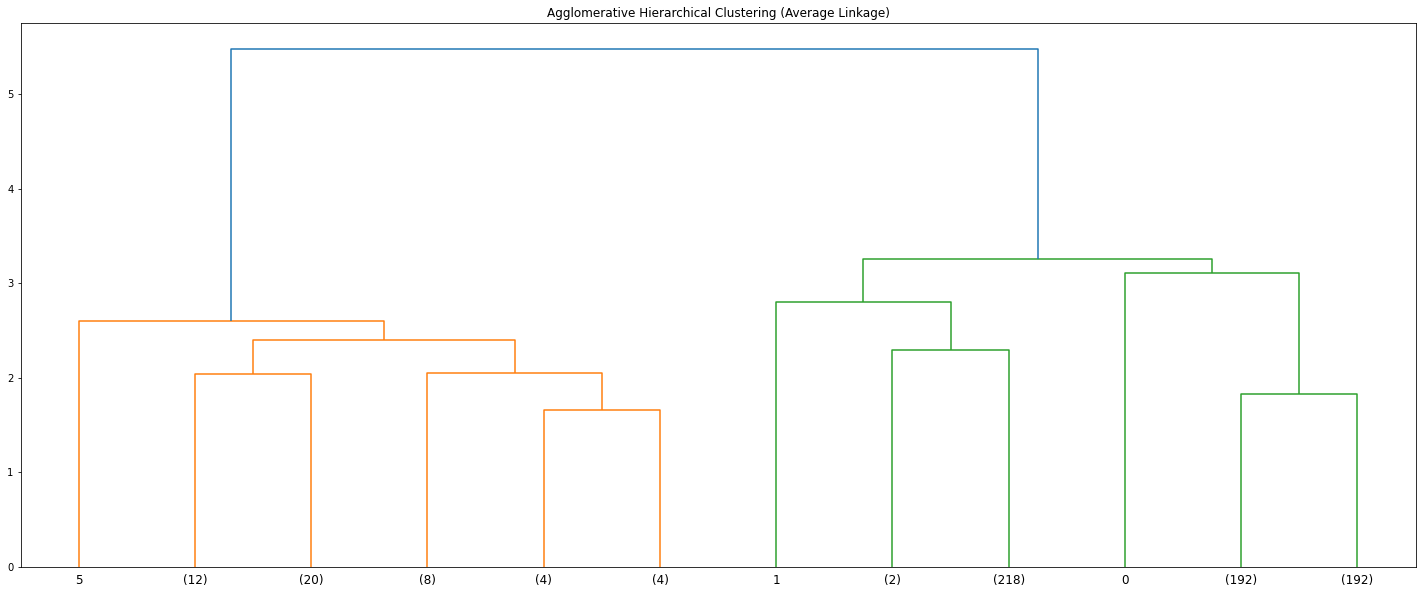

In [30]:
plt.figure(figsize=(25,10))
plt.title('Agglomerative Hierarchical Clustering (Average Linkage)')
dendrogram(za, truncate_mode='lastp', p = 12)
plt.show()

Agglomerative Clustering with Ward linkage

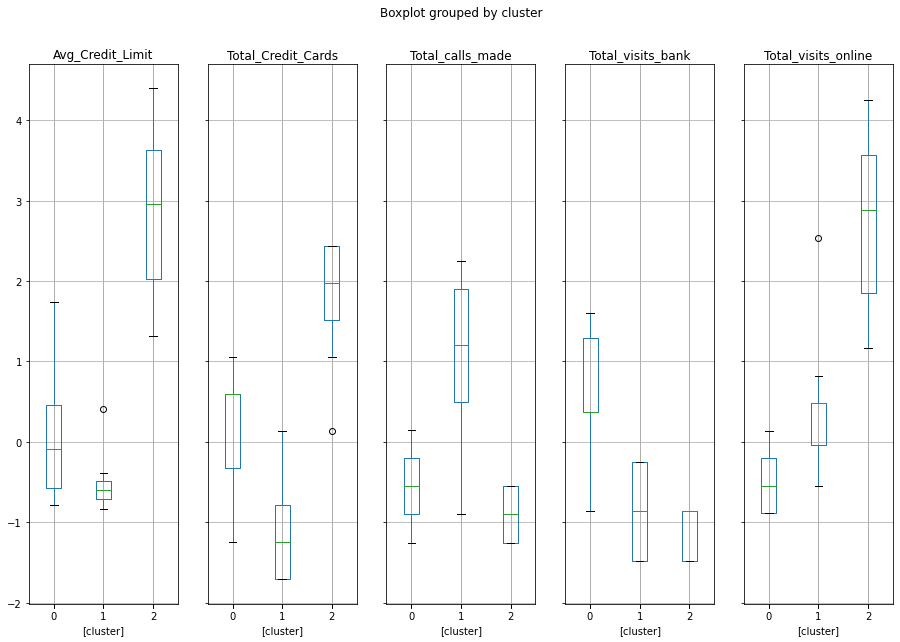

In [31]:
hca_w = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hca_w.fit(bData_z)
bDataZL_hcw = bData_z.copy()
bDataZL_hcw['cluster'] = hca_w.labels_
bDataZL_hcw.boxplot(by='cluster', layout=(1,5), figsize=(15,10));

In [32]:
zw = linkage(bData_z, metric='euclidean', method='ward')
cw, cophe_s = cophenet(zw, pdist(bData_z))
cw

0.7399284005362226

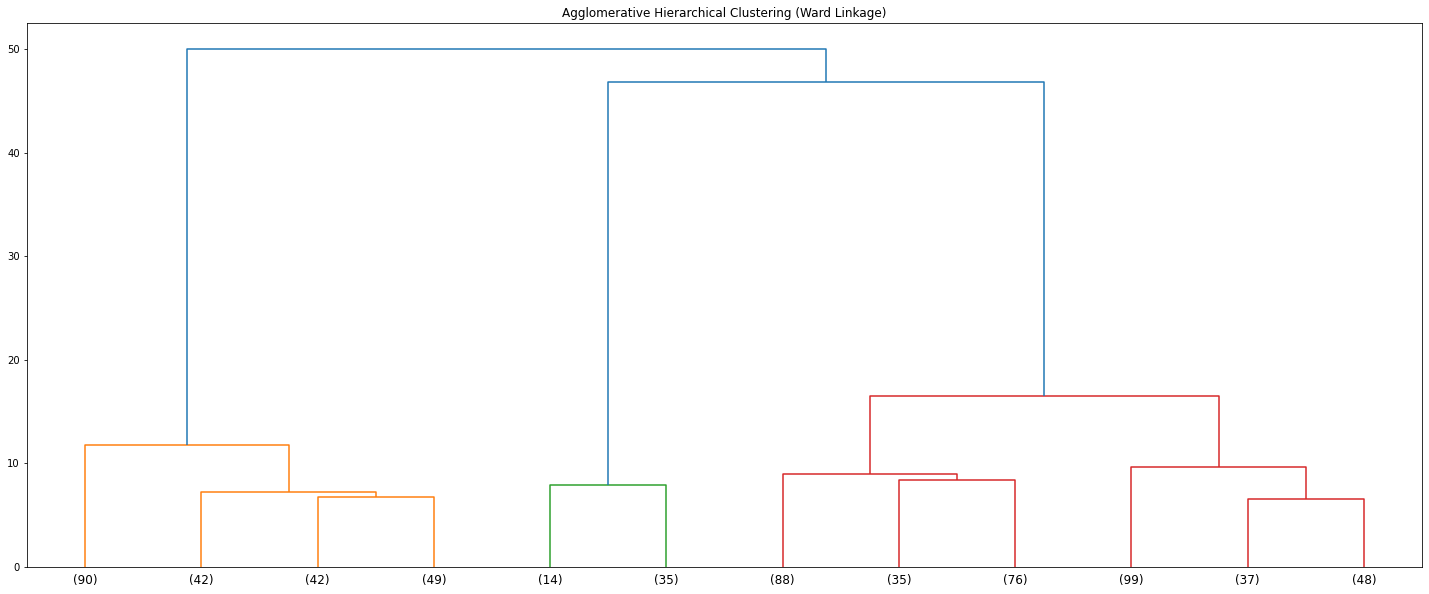

In [33]:
plt.figure(figsize=(25,10))
plt.title('Agglomerative Hierarchical Clustering (Ward Linkage)')
dendrogram(zw, truncate_mode='lastp', p = 12)
plt.show()

### Model comparison using Silhouette Score

In [34]:
from sklearn.metrics import silhouette_score

In [35]:
results = pd.DataFrame(columns=['Method', 'SScore'])
#KMeans
results = results.append({'Method':'KMeans', 'SScore':silhouette_score(bData_z, km.labels_)}, ignore_index=True) 
#Hierarchical Clustering 
results = results.append({'Method':'HCA_single  ', 'SScore':silhouette_score(bData_z, hca_s.labels_)}, ignore_index=True) 
results = results.append({'Method':'HCA_complete', 'SScore':silhouette_score(bData_z, hca_c.labels_)}, ignore_index=True) 
results = results.append({'Method':'HCA_average ', 'SScore':silhouette_score(bData_z, hca_a.labels_)}, ignore_index=True) 
results = results.append({'Method':'HCA_ward    ', 'SScore':silhouette_score(bData_z, hca_w.labels_)}, ignore_index=True) 
results.sort_values(by=['SScore'], ascending=False  )

,Method,SScore
3,HCA_average,0.515884
0,KMeans,0.515676
4,HCA_ward,0.514712
2,HCA_complete,0.514450
1,HCA_single,0.376456


BoxPlot Comparison KMeans / HCA_Average

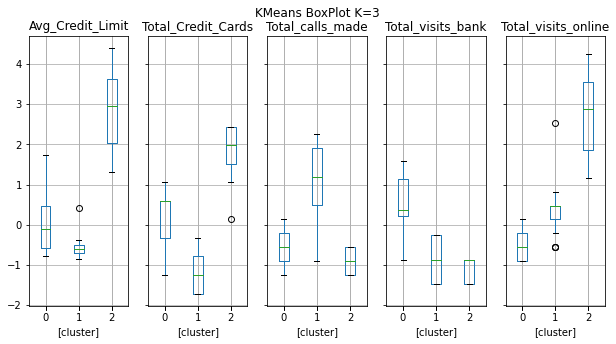

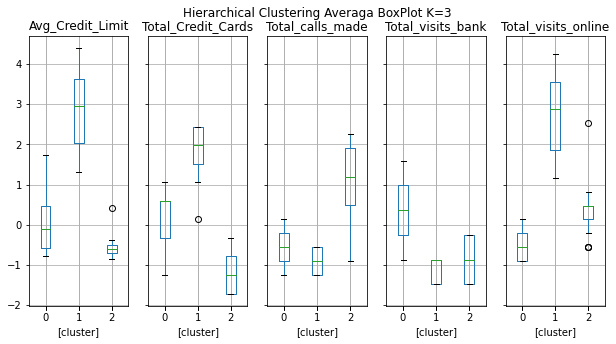

In [36]:
bDataZL.boxplot(by='cluster', layout=(1,5), figsize=(10,5),);
plt.suptitle("KMeans BoxPlot K=3")
plt.show()
bDataZL_hca.boxplot(by='cluster', layout=(1,5), figsize=(10,5));
plt.suptitle("Hierarchical Clustering Averaga BoxPlot K=3")
plt.show()

In [38]:
bDataK = bData.copy()
bDataK['cluster_K'] = km.labels_
bDataK.groupby('cluster_K').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster_K,,,,,
0,33809.895833,5.523438,3.481771,0.986979,2.005208
1,12180.180180,2.405405,0.936937,3.567568,6.851351
2,141877.551020,8.795918,0.612245,10.877551,1.040816


In [39]:
bDataH = bData.copy()
bDataH['cluster_HA'] = hca_a.labels_
bDataH.groupby('cluster_HA').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster_HA,,,,,
0,33740.25974,5.519481,3.477922,0.989610,2.010390
1,141877.55102,8.795918,0.612245,10.877551,1.040816
2,12203.61991,2.398190,0.932127,3.574661,6.864253


Analysing these two methods: 

KMeans and Hierarchical clustering techniques we can notice, both methods uses a K = 3 (3 clusters). 
The Box Plots show almost the same cluster distribution and size, but in different order.


### Conclutions / Answering Key Questions

#### How many different segments of customers are there?
There are 3 differnt customer´s segments

#### How are these segments different from each other?

    We can identify that there are 3 leveles of credit limit, let's say, High, Medium and Low, each of these segments, have its corresponding amount of credit cards. If we take this, we can see how each segment uses on-line bank serverices and how often theses customer's segmente visit the bank and how many calls they make to the call centre.

##### High Credit Limit (141.8K avg):
    Has the most credit cards (8.8 credit cards avg.) 
    Visits less often the bank (.6 times avg.)
    Calls less often to call centre (1.04 times avg.)
    Uses more bank on-line services (10.87 times avg.)
    
##### Medium Credit Limit (33.7K avg):
    Has credit cards (5.6 credit cards avg.) 
    Visits the bank (3.47 times avg.)
    Calls less often to call centre (2.01 times avg.)
    Uses more bank on-line services (.98 times avg.)
    

##### Low Credit Limit (12.2K avg):
    Has the fewer credit cards (2.3 credit cards avg.) 
    Visits less often the bank (.93 times avg.)
    Calls the most often to call centre (6.8 times avg.)
    Uses the less bank on-line services (3.57 times avg.)
    
    

#### What are your recommendations to the bank on how to better market to and service these customers?

1.- The segment with the Highest Credit Limits, cost less to the bank because it uses the more on-line services and it has to be less frequent attended by personnel's bank (Bank branch and Call Centre). With this in mind, I recommend making a stronger effort in marketing this segment.
 
2.- Another kind of marketing strategy could be an informative one targeted to the Lower Credit Limit customers segment to reduce costs on supporting them and lower the calls to the call centre.